In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PyCrystalField as cef
import scipy
from scipy.optimize import minimize
from scipy.optimize import leastsq
import pandas as pd
import lmfit

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



In [615]:
B20 = -3.559e-2
B40 = -3.849e-4
B43 = -1.393e-2
B60 = 3.154e-6
B63 = -4.695e-6
B66 = 3.3815e-5
# B20 = -2.773e-2
# B40 = -3.987e-4
# B43 = -1.416e-2
# B60 = 3.152e-6
# B63 = -7.616e-6
# B66 = 3.275e-5


temperature = 10 # in K

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K];
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'
kBT =kB*temperature

# Import data and normalize

In [431]:
fname = '/Users/hopeless/Desktop/LeeLab/data/Maglab_IRMeasurement_June2022/ProcessingCode/Load1_TrimData/P2_CsEr_100-FIR_RAWAVG.dat'


rawData = pd.read_csv(fname, index_col=0, skiprows=0, header=1)
normDataB = rawData.dropna(axis = 0)
# normDataB = normDataB.iloc[0:4000, :]
normDataB = normDataB.dropna(axis=1)
normDataB = normDataB.drop(labels = '-1.1', axis=1)

normSpec = rawData['0.001']/max(rawData['0.001'])
avgSpec = normSpec
for column in normDataB.columns: 
    # in a dataframe, column is a key
    normDataB[column] = max(normDataB[column]) -normDataB[column]
    normDataB[column] = normDataB[column]/(max(normDataB[column])) -normSpec
    avgSpec = avgSpec + normDataB[column]

len(rawData.columns)
for column in normDataB.columns: 
    normDataB[column] = normDataB[column]-avgSpec/len(rawData.columns)
    normDataB[column] = normDataB[column]-(sum(normDataB[column])/len(normDataB[column]))
normDataB = normDataB.drop(labels='0.001', axis=1)
# drop data above 120 cm-1 -> spec is useless above there, so we really want to remove it

for index in normDataB.index:
    if index<20: 
        normDataB = normDataB.drop(labels=index , axis = 0)
    if index>110:
        normDataB = normDataB.drop(labels=index , axis = 0)



In [241]:
normDataB = (normDataB/normDataB.max())

In [434]:
# lets get bfield + wavenum arrays from the dataframe
Bfield = [float(b) for b in normDataB.columns.values]
wavenums = [float(i) for i in normDataB.index.values]

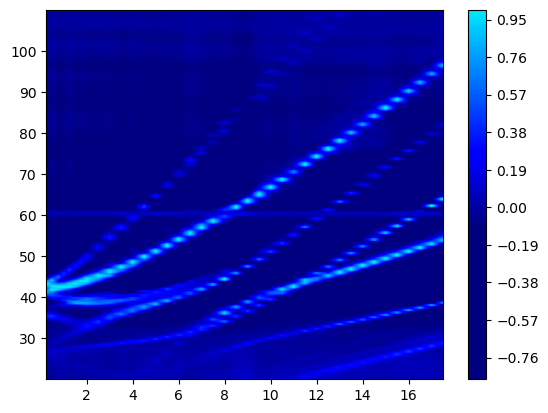

In [243]:
# quickly plot to make sure data doesn't look terrible
plt.ion()
plt.contourf(Bfield, wavenums, normDataB, 200, cmap = 'jet')
plt.clim(-0.1,3)
plt.colorbar()


# define the functions we need
usually, I do this by creating a class to do what I want, so I wouldn't have to keep redefining functions
I have not done this yet because there's so many different datasets and they are all formatted slightly differently

In [730]:
# functions we'll use to fit

def gaussian(x, amp,cen , wid):
    return amp * np.exp(-(x-cen)**2 / wid)

def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay)

def diagonalize(ionObj, ion, Field): 
    JdotB = muB*(Field*cef.Operator.Jx(ionObj.J))*cef.LandeGFactor(ion)
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 

def zeemanSplit(field, wavenum, B20, B40, B43, B60, B63, B66):     
    # assuming only H||B rn
    # assuming that x is an array
    amp = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]#[0, .15, .15, .2, 0.15,0.15,0.15,0.15,0.07,0.07, .1,.1,.1,.1,.1]
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    try: # for the case we pass in a single B val
        evals = diagonalize(ionObj, ion, field)
        dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
        # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
        # we can make between them, so we can make this now
        # Z = sum_i (e^(-beta*E_i))
        Z = [np.exp(-Ei/kBT) for Ei in dE]
        Z = sum(Z)
        # now that we have the partition fn, we can calculate probabilities
        p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
        # okay, so now we want to add lines between non ground states 
        # we want the amplitude to be the probability -> main lines are already determined
        numLines = len(dE)
        for i in range(1,numLines): 
            # skip GS - already have those dE
            for j in range(i+1, numLines):
                temp = dE[j]-dE[i]
                dE.append(temp)
                amp.append(p[i]*amp[i])
        # so now we want to create a multi gaussian with centers at the eigenvalues
        wid = .5 # pulled this out my ass, .5cm-1 resolution roughly
        a = amp[0] #+ m[0]*field
        centers =dE 
        fun = gaussian(wavenum, a, centers[0]*meVToCm, wid)
        for i in range(len(centers[1:])):
            a = amp[i]# +m[i]*field
            fun += gaussian(wavenum, a, centers[i]*meVToCm, wid)
    except AttributeError : # for when we pass in an array 
        # pyCrystalField has trouble with the operators because its not *just* a function
        # so this error handling lets us have a function that works for single values and array inputs
        fun = []
        for b in field: 
            evals = diagonalize(ionObj, ion, b)
            dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
            # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
            # we can make between them, so we can make this now
            # Z = sum_i (e^(-beta*E_i))
            Z = [np.exp(-Ei/kBT) for Ei in dE]
            Z = sum(Z)
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = len(dE)
            for i in range(1,2): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE[j]-dE[i]
                    dE.append(temp)
                    amp.append(p[i])
            # so now we want to create a multi gaussian with centers at the eigenvalues
            wid = .3 # pulled this out my ass, .5cm-1 resolution roughly
            a = amp[0] #+ m[0]*field
            centers =dE 
            tempfun = gaussian(wavenum, a, centers[0]*meVToCm, wid)
            for i in range(len(centers[1:])):
                a = amp[i]# +m[i]*field
                tempfun += gaussian(wavenum, a, centers[i]*meVToCm, wid)
            fun.append(tempfun)
    return fun

# functions we'll use to plot
def zeemanSplit3d(ionObj, ion, Field): 
    # ion input is cef.CFLevels.Bdict(ion,Bparams) type of variable
    # magnetic hamiltonian -> here we are using a magnetic dipole in a uniform, static field
    # this gives potential V = -mu.B
    # for our electrons, we can rewrite mu = gumBJ, with some prefactor
    # here J is our total ang mom. J = L+S
    JdotB = muB*(Field[0]*cef.Operator.Jx(ionObj.J) + Field[1]*cef.Operator.Jy(ionObj.J) + Field[2]*cef.Operator.Jz(ionObj.J))*cef.LandeGFactor(ion)
    #we've defined this as a CFLevels object
    # define just the CEF hamiltonian
    # H = ionObj.H # this is built into the CFLevels class. see pycrystal field doc
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    # its just a sum of the stevens operators and the corresponding params
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 

def calculateZeemanSpec(ionObj,ion, Bfield): 
    # actually calculate your splitting for a giving field in 3d
    calcA = []
    calcB = [] 
    calcC = []
    for B in Bfield: 
        calcA.append(zeemanSplit3d(ionObj, ion, [B, 0, 0])*meVToCm)
        calcB.append(zeemanSplit3d(ionObj, ion, [0, B, 0])*meVToCm)
        calcC.append(zeemanSplit3d(ionObj, ion, [0, 0, B])*meVToCm)
    calcA = np.array(calcA)
    calcB = np.array(calcB)
    calcC = np.array(calcC)
    return calcA, calcB, calcC

def dummyModelB(B20, B40, B43, B60, B63, B66): 
    Bparams = {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionCef = cef.CFLevels.Bdict(ion,Bparams)
    calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, Bfield)
    return calcB.T
    
def fun(x, y, B20, B40, B43, B60, B63, B66):
    arr = []
    for field in x: 
        arr.append(zeemanSplit(field, y, B20, B40, B43, B60, B63, B66))
    return arr

def plotCalcZSpec(calcArr, Bfield): 
    plt.ion()
    for i in range(len(calcArr)):
        plt.plot(calcArr[i],Bfield,  'r', linestyle = '-', marker = ' ') 
    return

# now let's do the fitting in lmfit?
starting guess params from https://journals.aps.org/prb/pdf/10.1103/PhysRevB.101.144432

In [258]:

model = lmfit.Model(zeemanSplit, independent_vars=['field', 'wavenum'])
params = model.make_params()
# initialize values, don't let me slide too far from initial vals
# I'm setting this max and min, because whatever we fit has to be at least
# *kinda* close to the neutron values
minVal = .01
maxVal = 100 # we want to stay within an order of magnitude
params['B20'].set(value= B20)
params['B40'].set(value= B40)
params['B43'].set(value= B43)
params['B60'].set(value= B60)
params['B63'].set(value= B63)
params['B66'].set(value= B66)

z = np.array(normDataB.to_numpy()) # gotta do it twice with tuples :((((
z = z.T

result = model.fit(z, field=Bfield, wavenum=wavenums, params =params)

In [259]:
print(result.fit_report())

[[Model]]
    Model(zeemanSplit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 834
    # data points      = 116493
    # variables        = 6
    chi-square         = 9820.61329
    reduced chi-square = 0.08430652
    Akaike info crit   = -288115.683
    Bayesian info crit = -288057.690
    R-squared          = -0.97544058
[[Variables]]
    B20: -0.04910422 +/- 4.6529e-05 (0.09%) (init = -0.03559)
    B40: -3.6483e-04 +/- 1.1373e-07 (0.03%) (init = -0.0003849)
    B43: -0.01474077 +/- 3.4562e-06 (0.02%) (init = -0.01393)
    B60:  3.1547e-06 +/- 8.7585e-10 (0.03%) (init = 3.154e-06)
    B63:  3.2378e-06 +/- 3.2609e-08 (1.01%) (init = -4.695e-06)
    B66:  4.2797e-05 +/- 4.2290e-08 (0.10%) (init = 3.3815e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(B20, B63) = -0.9628
    C(B20, B43) = +0.9492
    C(B43, B66) = -0.9364
    C(B20, B66) = -0.9054
    C(B43, B63) = -0.8860
    C(B63, B66) = +0.8101
    C(B20, B40) = -0.6233
    C(B40, B66

# okay, so since we have an lmfit model, lets plot this first pass at a fit

In [589]:
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0.1,18, 100)

arr = zeemanSplit(fieldArr, waveArr, B20, B40, B43, B60, B63, B66) 
# arr = zeemanSplit(fieldArr, waveArr,result.params['B20'], result.params['B40'], result.params['B43'], result.params['B60'], result.params['B63'], result.params['B66']) 
arr = np.array(arr)


Text(0.5, 1.0, 'CsErSe2 H||b real data')

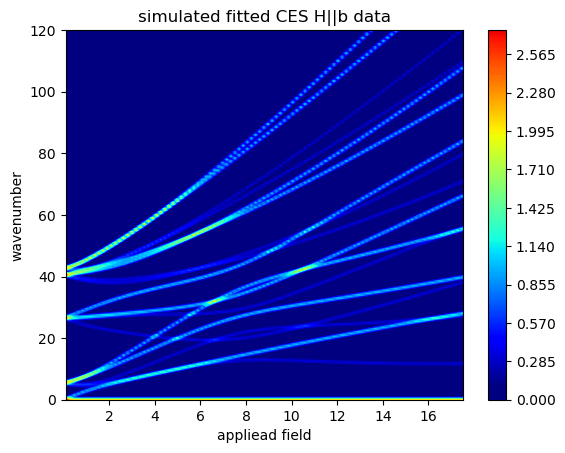

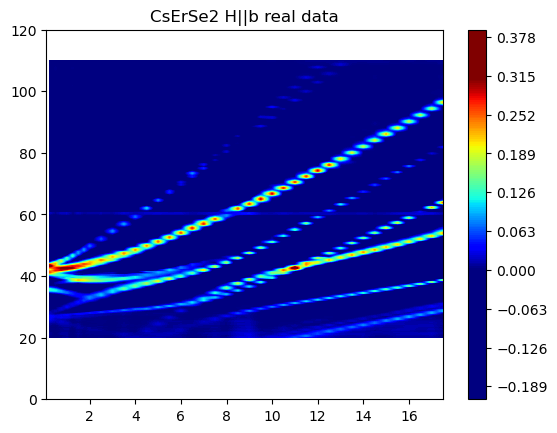

In [590]:
plt.contourf(fieldArr,waveArr,arr.T, 100, cmap='jet')
plt.xlim(0.1,17.5)
plt.ylim(0,120)
plt.clim(.1,3)
plt.title('simulated fitted CES H||b data')
plt.xlabel('applied field')
plt.ylabel('wavenumber')
plt.colorbar()

plt.figure()
plt.contourf(Bfield, wavenums, normDataB,200, cmap ='jet')
plt.xlim(0.1,17.5)
plt.ylim(0,120)
plt.clim(0,.31)
plt.colorbar()
plt.title('CsErSe2 H||b real data')

Text(0, 0.5, 'Applied Field (T)')

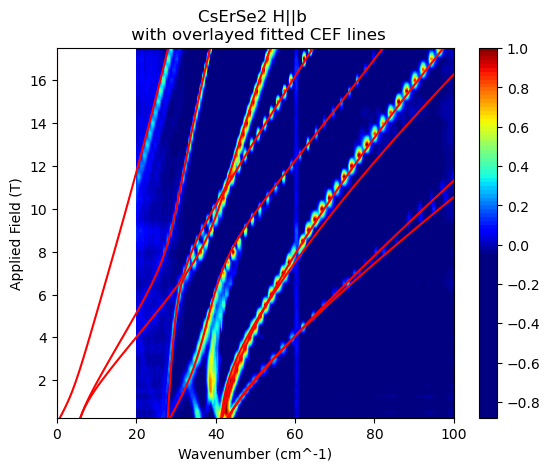

In [264]:
# and now let's plot with lines on top
calc = dummyModelB(result.params['B20'], result.params['B40'], 
                   result.params['B43'], result.params['B60'], 
                   result.params['B63'], result.params['B66'])

plt.figure()
plotCalcZSpec(calc, Bfield)
plt.contourf(wavenums, Bfield, normDataB.T,100, cmap ='jet')
plt.colorbar()
plt.clim(-0.05,1)
plt.title('CsErSe2 H||b \n with overlayed fitted CEF lines')
plt.xlim(0,100)
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Applied Field (T)')


# now, let's plot the secondary lines as lines
choose color as probability

In [577]:
def zeemanSplitLines(field, B20, B40, B43, B60, B63, B66):     
    # assuming only H||B rn
    # assuming that x is an array
    amp = []#[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]#[0, .15, .15, .2, 0.15,0.15,0.15,0.15,0.07,0.07, .1,.1,.1,.1,.1]
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    kBT = 20*kB
    try: # for the case we pass in a single B val
        evals = diagonalize(ionObj, ion, field)
        dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
        # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
        # we can make between them, so we can make this now
        # Z = sum_i (e^(-beta*E_i))
        Z = [np.exp(-Ei/kBT) for Ei in dE]
        Z = sum(Z)
        # now that we have the partition fn, we can calculate probabilities
        p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
        # okay, so now we want to add lines between non ground states 
        # we want the amplitude to be the probability -> main lines are already determined
        numLines = len(dE)
        for i in range(1,numLines): 
            # skip GS - already have those dE
            for j in range(i+1, numLines):
                temp = dE[j]-dE[i]
                dE.append(temp)
        amp.append(p)
        # so now we want to create a multi gaussian with centers at the eigenvalues
    except AttributeError : # for when we pass in an array 
        # pyCrystalField has trouble with the operators because its not *just* a function
        # so this error handling lets us have a function that works for single values and array inputs
        amp = []
        dE = []
        for b in field: 
            evals = diagonalize(ionObj, ion, b)
            dE_temp =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
            # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
            # we can make between them, so we can make this now
            # Z = sum_i (e^(-beta*E_i))
            Z = [np.exp(-Ei/kBT) for Ei in dE_temp]
            Z = sum(Z)
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE_temp]
            # temp_amp = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = len(dE_temp)
            for i in range(1,numLines): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE_temp[j]-dE_temp[i]
                    dE_temp.append(temp)
                    # temp_amp.append(p[i])
            dE.append(dE_temp)
            amp.append(p)
    return amp, dE

In [578]:
# so now we want to call our function to jsut make lines
# this will be horrible oof
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0,18, 100)

# amp, arr = zeemanSplitLines(fieldArr, result.params['B20'], result.params['B40'], 
                #    result.params['B43'], result.params['B60'], 
                #    result.params['B63'], result.params['B66'])

amp, arr = zeemanSplitLines(fieldArr, B20, B40, 
                   B43, B60, 
                   B63, B66)

arr = np.array(arr)
arr = arr*meVToCm
arr = arr.T

amp = np.array(amp)
amp = amp.T
# amp = amp.T

Text(0.5, 1.0, 'line population as a function of field \n at 20K')

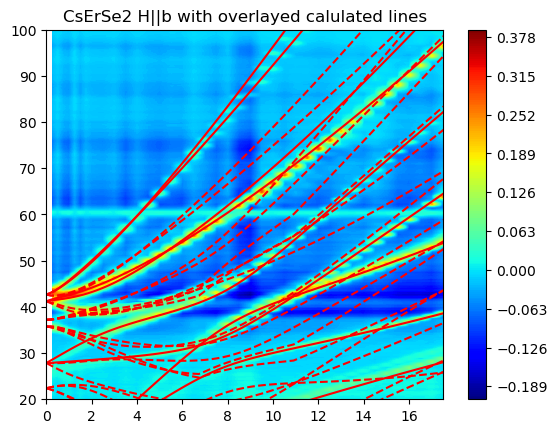

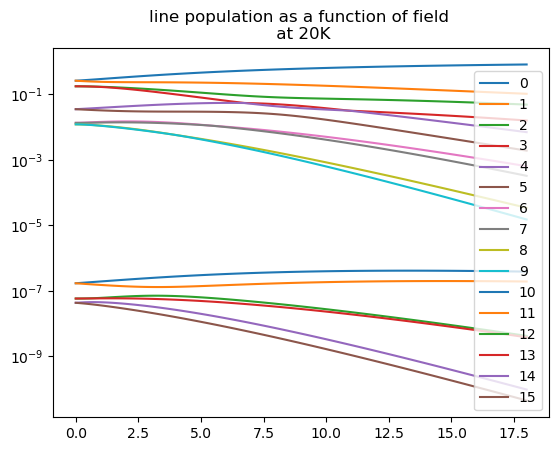

In [580]:
plt.contourf(Bfield, wavenums, normDataB,200, cmap ='jet')
plt.xlim(0,17.5)
plt.ylim(0,120)
# plt.clim(-0.05,1)
plt.colorbar()
plt.title('CsErSe2 H||b with overlayed calculated lines')
for i in range(50):
    if i<16: 
        plt.plot(fieldArr, arr[i], 'r')
    if i>=16: 
        plt.plot(fieldArr, arr[i], 'r--')

plt.ylim(20, 100)

fig = plt.figure()
for i in range(len(amp)):
    plt.plot(fieldArr, amp[i], label =str(i))
plt.yscale('log')
plt.legend()
plt.title('line population as a function of field \n at 20K')

# plt.colorbar()


# do along c axis


# first, let's try and find the c axis data

In [653]:
fname = '/Users/hopeless/Downloads/MikeOzerovsfiles_IR_June2022/2ndload_Jun03/P3_CsEr_NormAVG.dat'


rawDataC = pd.read_csv(fname, index_col=0, skiprows=0, header=1)
normDataC = rawData.dropna(axis = 0)
# normDataB = normDataB.iloc[0:4000, :]
normDataC = normDataC.dropna(axis=1)
normDataC = normDataC.drop(labels = '-1.1', axis=1)
normDataC = normDataC.values.max()-normDataC


for index in normDataC.index:
    if index<10: 
        normDataC = normDataC.drop(labels=index , axis = 0)
    if index>110:
        normDataC = normDataC.drop(labels=index , axis = 0)
        
temp = normDataC

In [706]:
normDataC = temp


In [699]:
for index in normDataC.index:
    for col in normDataC.columns: 
        if normDataC.loc[index, col] <0: 
            normDataC.loc[index, col] = 0

In [700]:
BfieldC = [float(b) for b in normDataC.columns.values]
wavenumsC = [float(i) for i in normDataC.index.values]

rawBfieldC = [float(b) for b in rawDataC.columns.values]
rawwavenumsC = [float(i) for i in rawDataC.index.values]
temp = normDataC

In [710]:
# so we want to invert this data
for col in normDataC.columns: 
    # normDataC[col] = normDataC[col]-normDataC[col].mean()
    # normDataC[col] = normDataC[col]-normDataC.loc[:,col].values.min()
    # normDataC[col] = normDataC[col]-normDataC[col].mean()
    normDataC[col] = normDataC[col]/normDataC.loc[:,col].values.max()
    # normDataC = normDataC*5


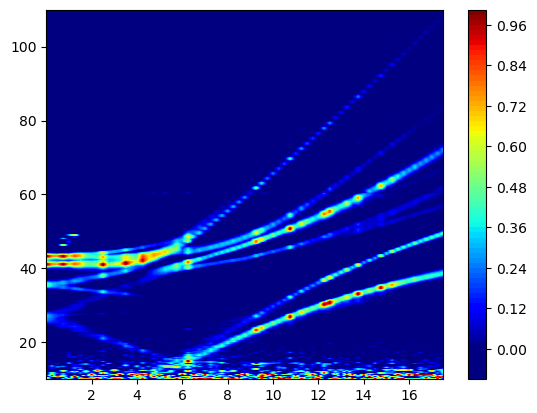

In [711]:
plt.contourf(BfieldC, wavenumsC, normDataC, 100, cmap='jet')
# plt.ylim(0,5000)
plt.colorbar()
plt.clim(0, 1)

In [507]:
def dummyModelC(B20, B40, B43, B60, B63, B66): 
    Bparams = {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionCef = cef.CFLevels.Bdict(ion,Bparams)
    calcA, calcB, calcC = calculateZeemanSpec(ionCef, ion, BfieldC)
    return calcC.T

Text(0, 0.5, 'Applied Field (T)')

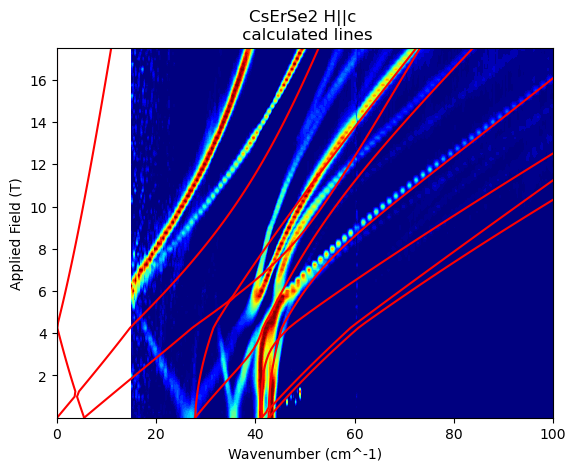

In [619]:
calcC = dummyModelC(result.params['B20'], result.params['B40'], 
                   result.params['B43'], result.params['B60'], 
                   result.params['B63'], result.params['B66'])

plt.figure()
plotCalcZSpec(calcC, BfieldC)
plt.contourf(wavenumsC, BfieldC, normDataC.T,100, cmap ='jet')
# plt.colorbar()
plt.clim(0, 1)
plt.title('CsErSe2 H||c \n calculated lines')
plt.xlim(0,100)
plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Applied Field (T)')

# right, so now this looks wrong because there aren't any doubled lines
# let's add the doubled lines


In [721]:
def diagonalizeC(ionObj, ion, Field, gz): 
    JdotB = muB*(Field*cef.Operator.Jz(ionObj.J))*gz #cef.LandeGFactor(ion)
    H = np.sum([a*b for a,b in zip(ionObj.O, ionObj.B)], axis=0)
    ionObj.diagonalize(H + JdotB.O) # this is just H = Hcef + Hmag
    return ionObj.eigenvalues 

def zeemanSplitLinesC(field, B20, B40, B43, B60, B63, B66, gz):     
    # assuming only H||B rn
    # assuming that x is an array
    amp = []#[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]#[0, .15, .15, .2, 0.15,0.15,0.15,0.15,0.07,0.07, .1,.1,.1,.1,.1]
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    kBT = 5*kB
    try: # for the case we pass in a single B val
        evals = diagonalizeC(ionObj, ion, field, gz)
        dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
        # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
        # we can make between them, so we can make this now
        # Z = sum_i (e^(-beta*E_i))
        Z = [np.exp(-Ei/kBT) for Ei in dE]
        Z = sum(Z)
        # now that we have the partition fn, we can calculate probabilities
        p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
        # okay, so now we want to add lines between non ground states 
        # we want the amplitude to be the probability -> main lines are already determined
        numLines = len(dE)
        for i in range(1,numLines): 
            # skip GS - already have those dE
            for j in range(i+1, numLines):
                temp = dE[j]-dE[i]
                dE.append(temp)
        amp.append(p)
        # so now we want to create a multi gaussian with centers at the eigenvalues
    except AttributeError : # for when we pass in an array 
        # pyCrystalField has trouble with the operators because its not *just* a function
        # so this error handling lets us have a function that works for single values and array inputs
        amp = []
        dE = []
        for b in field: 
            evals = diagonalizeC(ionObj, ion, b, gz)
            dE_temp =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
            # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
            # we can make between them, so we can make this now
            # Z = sum_i (e^(-beta*E_i))
            Z = [np.exp(-Ei/kBT) for Ei in dE_temp]
            Z = sum(Z)
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE_temp]
            # temp_amp = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = len(dE_temp)
            for i in range(1,numLines): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE_temp[j]-dE_temp[i]
                    dE_temp.append(temp)
                    # temp_amp.append(p[i])
            dE.append(dE_temp)
            amp.append(p)
    return amp, dE

In [627]:
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0,18, 100)

ampC, arrC = zeemanSplitLinesC(fieldArr,result.params['B20'], result.params['B40'], 
                   result.params['B43'], result.params['B60'], 
                   result.params['B63'], result.params['B66'])

# ampC, arrC = zeemanSplitLines(fieldArr, B20, B40, B43, B60, B63, B66)
arrC = np.array(arrC)
arrC = arrC*meVToCm
arrC = arrC.T

ampC = np.array(ampC)
ampC = ampC.T

ValueError: x and y must have same first dimension, but have shapes (100,) and (16000,)

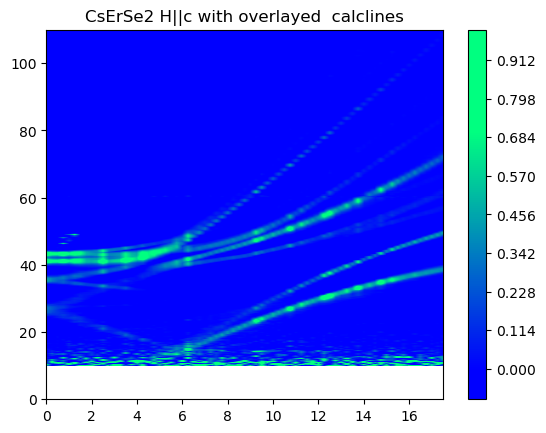

In [731]:
plt.contourf(BfieldC, wavenumsC, normDataC,200, cmap='winter')
plt.xlim(0,17.5)
plt.ylim(0,110)
plt.clim(0, .7)
plt.colorbar()
plt.title('CsErSe2 H||c with overlayed  calclines')
for i in range(40):
    if i<16: 
        plt.plot(fieldArr, arrC[i], 'r')
    if i>=16: 
        plt.plot(fieldArr, arrC[i], 'r--')

# plt.ylim(20, 100)

# fig = plt.figure()
# for i in range(len(ampC)):
#     plt.plot(fieldArr, ampC[i], label =str(i))
# plt.yscale('log')
# plt.legend()


# okay, so now lets repeat the fit for the c axis
and pass in the lines we fit from ab
Ideally, I want to fit the a&b simultaneously
hmmmm......
can I pass in both sets of data and write a sim function that does both? probably. Figure out how to do this....
... could be easy if I just add an artificial - in B to put the two plots next to each other, and just like, fit them side by side....

In [714]:
# now lets fit to the C axis
def zeemanSplitC(field, wavenum, B20, B40, B43, B60, B63, B66, gz):     
    # assuming only H||B rn
    # assuming that x is an array
    amp = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1,]#[0, .15, .15, .2, 0.15,0.15,0.15,0.15,0.07,0.07, .1,.1,.1,.1,.1]
    Bparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
    ionObj = cef.CFLevels.Bdict(ion,Bparams)
    try: # for the case we pass in a single B val
        evals = diagonalizeC(ionObj, ion, field, gz)
        dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
        # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
        # we can make between them, so we can make this now
        # Z = sum_i (e^(-beta*E_i))
        Z = [np.exp(-Ei/kBT) for Ei in dE]
        Z = sum(Z)
        # now that we have the partition fn, we can calculate probabilities
        p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
        # okay, so now we want to add lines between non ground states 
        # we want the amplitude to be the probability -> main lines are already determined
        numLines = len(dE)
        for i in range(1,numLines): 
            # skip GS - already have those dE
            for j in range(i+1, numLines):
                temp = dE[j]-dE[i]
                dE.append(temp)
                amp.append(p[i]*amp[i])
        # so now we want to create a multi gaussian with centers at the eigenvalues
        wid = .5 # pulled this out my ass, .5cm-1 resolution roughly
        a = amp[0] #+ m[0]*field
        centers =dE 
        fun = gaussian(wavenum, a, centers[0]*meVToCm, wid)
        for i in range(len(centers[1:])):
            a = amp[i]# +m[i]*field
            fun += gaussian(wavenum, a, centers[i]*meVToCm, wid)
    except AttributeError : # for when we pass in an array 
        # pyCrystalField has trouble with the operators because its not *just* a function
        # so this error handling lets us have a function that works for single values and array inputs
        fun = []
        for b in field: 
            evals = diagonalizeC(ionObj, ion, b, gz)
            dE =[eval for eval in evals] # this is the spitting if everything is in the GS -> not necessarily true for finite temp
            # first, lets calculate the partition function - the microstates of the system don't change, jsut the number of abs line
            # we can make between them, so we can make this now
            # Z = sum_i (e^(-beta*E_i))
            Z = [np.exp(-Ei/kBT) for Ei in dE]
            Z = sum(Z)
            # now that we have the partition fn, we can calculate probabilities
            p = [1/Z*np.exp(-Ei/kBT) for Ei in dE]
            # okay, so now we want to add lines between non ground states 
            # we want the amplitude to be the probability -> main lines are already determined
            numLines = len(dE)
            for i in range(1,numLines): 
                # skip GS - already have those dE
                for j in range(i+1, numLines):
                    temp = dE[j]-dE[i]
                    dE.append(temp)
                    amp.append(p[i])
            # so now we want to create a multi gaussian with centers at the eigenvalues
            wid = .3 # pulled this out my ass, .5cm-1 resolution roughly
            a = amp[0] #+ m[0]*field
            centers =dE 
            tempfun = gaussian(wavenum, a, centers[0]*meVToCm, wid)
            for i in range(len(centers[1:])):
                a = amp[i]# +m[i]*field
                tempfun += gaussian(wavenum, a, centers[i]*meVToCm, wid)
            fun.append(tempfun)
    return fun

In [715]:

model = lmfit.Model(zeemanSplitC, independent_vars=['field', 'wavenum'])
paramsC = model.make_params()

paramsC['B20'].set(value= result.params['B20'])
paramsC['B40'].set(value= result.params['B40'])
paramsC['B43'].set(value= result.params['B43'])
paramsC['B60'].set(value= result.params['B60'])
paramsC['B63'].set(value= result.params['B63'])
paramsC['B66'].set(value= result.params['B66'])
paramsC['gz'].set(value= cef.LandeGFactor(ion))

z = np.array(normDataB.to_numpy()) # gotta do it twice with tuples :((((
z = z.T

resultC = model.fit(z, field=Bfield, wavenum=wavenums, params =paramsC)

In [725]:
float(resultC.params['gz'])

1.2845843805641284

In [726]:
# now plot the fit: 
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0,18, 100)

ampCfit, arrCfit = zeemanSplitLinesC(fieldArr,resultC.params['B20'], resultC.params['B40'], 
                   resultC.params['B43'], resultC.params['B60'], 
                   resultC.params['B63'], resultC.params['B66'], float(resultC.params['gz']))
arrCfit = np.array(arrCfit)
arrCfit = arrCfit*meVToCm
arrCfit = arrCfit.T

# ampCfit = np.array(ampCfit)
# ampCfit = ampCfit.T

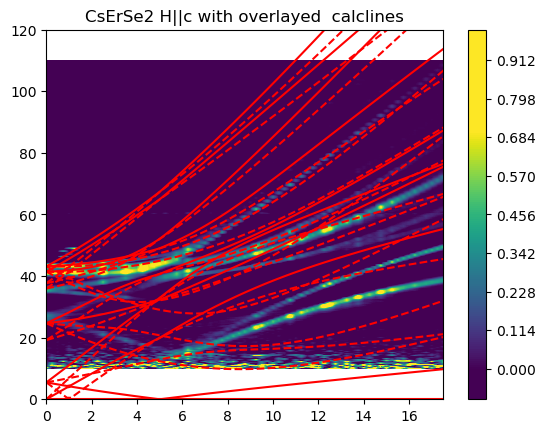

In [727]:
plt.contourf(BfieldC, wavenumsC, normDataC,200)
plt.xlim(0,17.5)
plt.ylim(0,120)
plt.clim(0, .7)
plt.colorbar()
plt.title('CsErSe2 H||c with overlayed  calclines')
for i in range(40):
    if i<16: 
        plt.plot(fieldArr, arrCfit[i], 'r')
    if i>=16: 
        plt.plot(fieldArr, arrCfit[i], 'r--')

# plt.ylim(20, 100)

# fig = plt.figure()
# for i in range(len(ampC)):
#     plt.plot(fieldArr, ampC[i], label =str(i))
# plt.yscale('log')
# plt.legend()

# so letting gz slide produces a better, but not perfect fit. 
I'm pretty concerned that some of the lowest energy lines just aren't characterized by this fit at all. 
I'm wondering if ignoring exchange for the ab plane is fine, but if it's more important here - I mean like the whole point
is to have super interesting spin texture along the c-axis, right? so like, it would make sense that this is more important


In [728]:
waveArr= np.linspace(0,8000, 16000)
fieldArr = np.linspace(0,18, 100)

arrC = zeemanSplitC(fieldArr, waveArr, resultC.params['B20'], resultC.params['B40'],resultC.params['B43']
                    ,resultC.params['B60'],resultC.params['B63'],resultC.params['B66'], float(resultC.params['gz'])) 
# arr = zeemanSplit(fieldArr, waveArr,result.params['B20'], result.params['B40'], result.params['B43'], result.params['B60'], result.params['B63'], result.params['B66']) 
arrC = np.array(arrC)

Text(0.5, 1.0, 'CsErSe2 H||c real data')

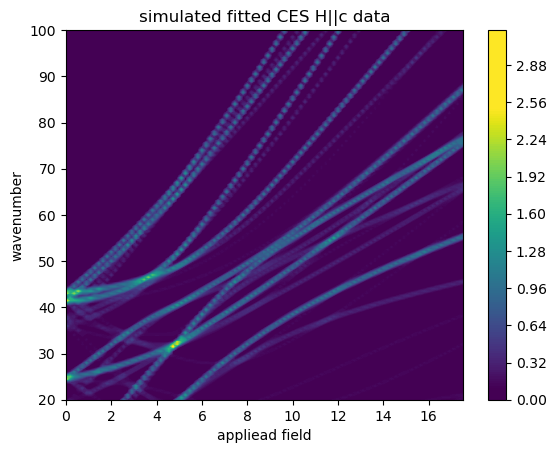

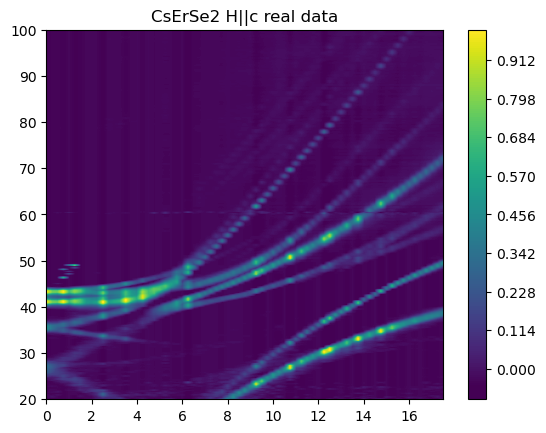

In [729]:
plt.contourf(fieldArr,waveArr,arrC.T, 200)
plt.xlim(0,17.5)
plt.ylim(20,100)
plt.clim(.1,2.5)
plt.title('simulated fitted CES H||c data')
plt.xlabel('appliead field')
plt.ylabel('wavenumber')
plt.colorbar()

plt.figure()
plt.contourf(BfieldC, wavenumsC, normDataC,200)
plt.xlim(0,17.5)
plt.ylim(20,100)
plt.clim(-0.05,1)
plt.colorbar()
plt.title('CsErSe2 H||c real data')

# so, what comes next? 
a couple things: -interaction term at least along the c-zxis
-simulatneous fits
-> I think we could really fit a, c, and magnetization/susceptibility in one go with a good data structure. 
it might be worth writing a class to do this. 
-that would mean getting the fuck out of jupyter, yee haw bitches